# AllLife Credit Card Customer Segmentation

**Problem:** Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster.

**Objective:** To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

**Key Questions:**
1. How many different segments of customers are there?
2. How are these segments different from each other?
3. What are your recommendations to the bank on how to better market to and service these customers?

### Data Dictionary
 - **Customer key** - Identifier for the customer
 - **Average Credit Limit** - Average credit limit across all the credit cards
 - **Total credit cards** - Total number of credit cards
 - **Total visits bank** - Total number of bank visits
 - **Total visits online** - total number of online visits
 - **Total calls made** - Total number of calls made by the customer

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

## Data read & Scope the Data

In [3]:
myData_raw = pd.read_excel("Credit Card Customer Data.xlsx")
myData_raw.head(17).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
Sl_No,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Customer Key,87073,38414,17341,40496,47437,58634,48370,37376,82490,44770,52741,52326,92503,25084,68517,55196,62617
Avg_Credit_Limit,100000,50000,50000,30000,100000,20000,100000,15000,5000,3000,10000,13000,11000,9000,6000,8000,15000
Total_Credit_Cards,2,3,7,5,6,3,5,3,2,4,4,3,1,1,2,2,2
Total_visits_bank,1,0,1,1,0,0,0,0,0,0,0,0,2,1,2,0,1
Total_visits_online,1,10,3,1,12,1,11,1,2,1,5,2,5,5,4,5,2
Total_calls_made,0,9,4,4,3,8,2,1,2,7,5,7,9,6,6,7,4


In [4]:
myData_raw.iloc[:,2:].size

3300

In [5]:
myData_raw.duplicated().sum()
# Duplicates need to be done before dropping any rows

0

In [6]:
myData_raw.isna().sum()
# Confirmation, no null values

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [7]:
myData_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


### Observations
 - All 7 columns are numerical 
     - Sl_No & Customer Key are of not statistically significant and shoul be dropped
     - 660 observations across the 5 valuable features
     - There will be 3300 data points after the data drop
 - No duplicate records
 - No Null Values

In [8]:
myData_raw.drop(['Sl_No','Customer Key'],axis=1,inplace=True)
# Dropping SI_NO & Customer Key they are not be useful for statistical analysis

In [9]:
myData_raw.columns
# Verified dropped

Index(['Avg_Credit_Limit', 'Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made'],
      dtype='object')

In [10]:
myData_raw.describe()

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.000000,660.000000,660.000000,660.000000,660.000000
mean,34574.242424,4.706061,2.403030,2.606061,3.583333
std,37625.487804,2.167835,1.631813,2.935724,2.865317
min,3000.000000,1.000000,0.000000,0.000000,0.000000
25%,10000.000000,3.000000,1.000000,1.000000,1.000000
50%,18000.000000,5.000000,2.000000,2.000000,3.000000
75%,48000.000000,6.000000,4.000000,4.000000,5.000000
max,200000.000000,10.000000,5.000000,15.000000,10.000000


#### Observations
The columms can be interpreted in two categories: Atributes & Interactions/Behaviors.

**Customer Attributes**
 - The median for Avg Credit Limit is 18k dollars
     - The range is 3K to 200k which indicates a large variance and many possible outliers
 - Most customers have 4 creditcards, with a moderate standard deviation of about 2 with max at 10 (possible outliers)

**Customer Interactions**
 - Total bank visits have a relative low standard deviation while Total visits online and Total calls made have a larger standard distribution, possibly indicating that most issues were resolve without having to visit the in person. There is not enough information. Having collected customer age/year of birth may have been a good data point to help clarify this.
     - Most customers have made at least 2 online & in person visits with the max of 15 and 5, respectively.
     - Most customers have made 3 calls with the max of 10 which may indicate frequest problems.

Overall, there seems to be a large spread of customer contact across the three 'Customer Interaction' features.

## Univariate Analysis

In [11]:
# ### Styling for visualizations
sns.set_style('darkgrid')
from matplotlib.pyplot import figure
# to adjust sizing 14-inches width is ideal for fitting the notebook.

In [12]:
cols=['Avg_Credit_Limit','Total_visits_online', 'Total_Credit_Cards', 'Total_visits_bank', 'Total_calls_made']
# creating my preferred order for visualizations

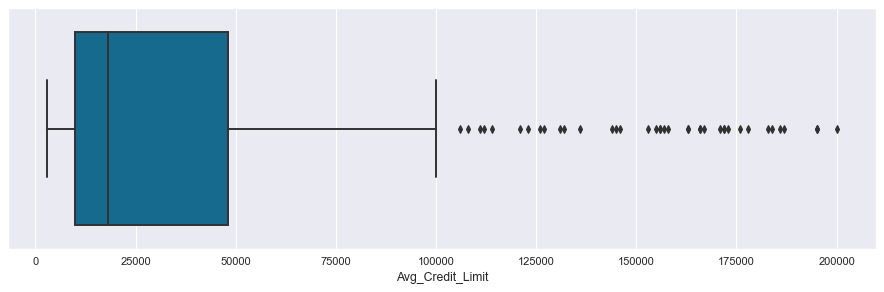

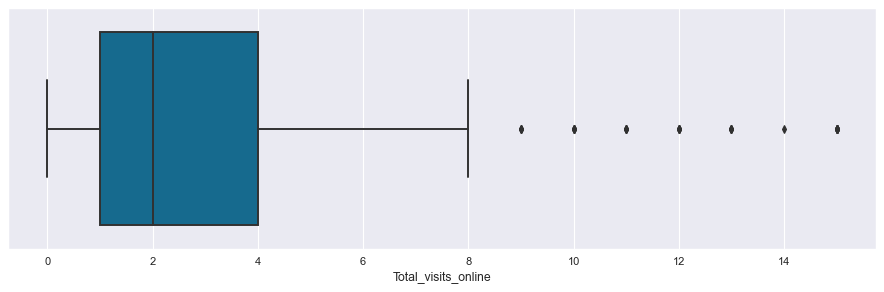

In [13]:
for i in range(2):
    figure(figsize=(14, 4), dpi=80)
    sns.boxplot(x=myData_raw[cols[i]])
    plt.show()
# Cycle through first two on my list with ouliers

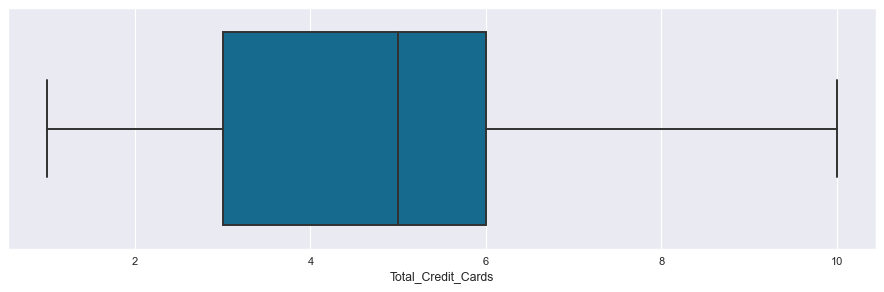

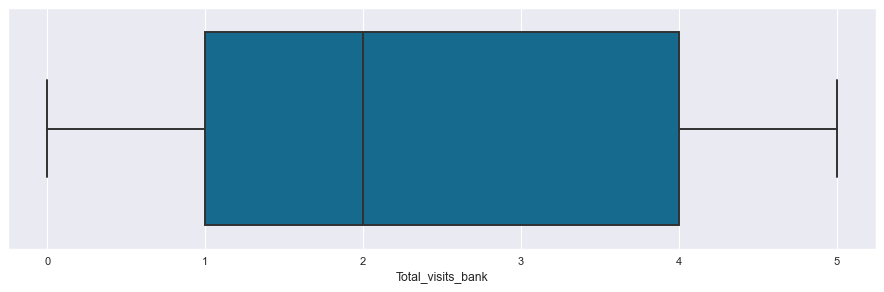

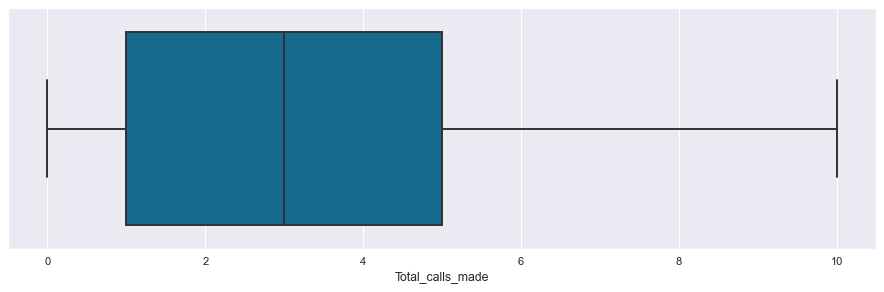

In [14]:
for i in range(5):
    if(i>1):
        figure(figsize=(14, 4), dpi=80)
        sns.boxplot(x=myData_raw[cols[i]])
        plt.show()
# Cycle through the rest on my list with ouliers

### Observations
**Client Attributes**
- There are upper outliers in the Average Credit Limit, there are many clients with very high credit scores.
- Majority of the people were above the median for Average Credit Limit. There may be a cluster for Average Credit Limit where we see the outliers as well as in 75th percentile and the 25th percentile. Possibly related to the amount of credit cards.
- Maximum credit cards were 10 which seems like a lot and may be a potential driver for interactions.

**Customer Interactions**
- There are upper outliers in the Total Visits Online above 8 vists.
- Total Vistits Online also had a large amount of people in the 75th percentile.
- Number of visits to the bank are between 2 and 4.
- Majority of the Total calls made by customers were 5 and below.

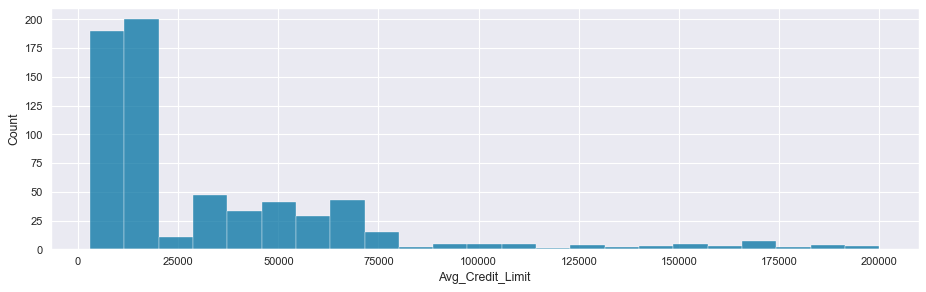

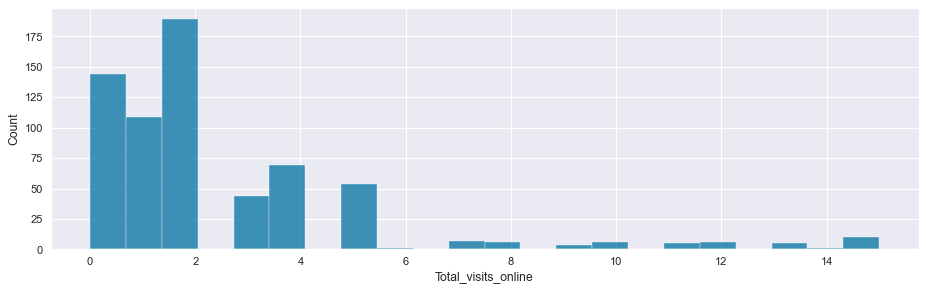

In [15]:
for i in range(2):
    figure(figsize=(14, 4), dpi=80)
    sns.histplot(myData_raw[cols[i]] )
    plt.show()

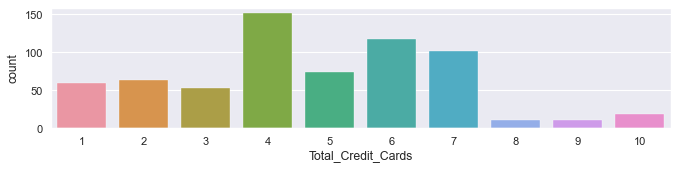

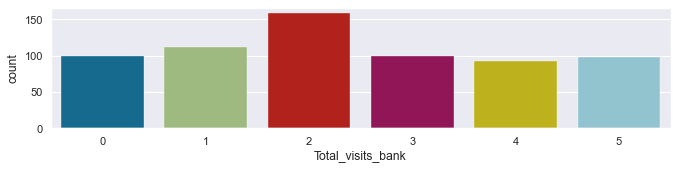

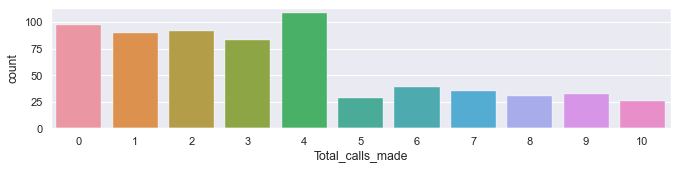

In [16]:
for i in range(5):
    if(i>1):
        figure(figsize=(10, 2), dpi=80)
        sns.countplot(myData_raw[cols[i]])
        plt.show()
# using a smaller size since these features are lower in spread and are more categorical in nature

### Observations
- Average Credit Limit appears to have a long-right-tail distribution. Looking at this distribution I predict 3 or more clusters seems like might be the right amount of clusters.

- Total Online Visis also seems to have a long-right-tail distribution.
- Total Credit Cards has a shorter right-tail distribution.
- Total Bank Visits seems to be normaly distributed with some emphasis on two vists.
- Total calls made has a sharp drop between 4 and 5 calls with a right-tailed distribution indicated many clients had to make calls compared to the no calls made.

## Data Treatment for Modeling

In [17]:
scalerObject = StandardScaler()
# Model instantiation

In [18]:
subset = myData_raw.copy()
# data copied

In [19]:
scaledData = scalerObject.fit_transform(myData_raw)
#  Fitting the StandardScaler object

In [20]:
myData_scaled = pd.DataFrame(scaledData, columns=cols)
myData_scaled
#  Creating dataframe with scaled data from transformed Scaler Object

,Avg_Credit_Limit,Total_visits_online,Total_Credit_Cards,Total_visits_bank,Total_calls_made
0,1.740187,-1.249225,-0.860451,-0.547490,-1.251537
1,0.410293,-0.787585,-1.473731,2.520519,1.891859
2,0.410293,1.058973,-0.860451,0.134290,0.145528
3,-0.121665,0.135694,-0.860451,-0.547490,0.145528
4,1.740187,0.597334,-1.473731,3.202298,-0.203739
...,...,...,...,...,...
655,1.713589,2.443892,-0.860451,2.520519,-1.251537
656,1.314621,2.443892,-0.860451,3.543188,-0.553005
657,2.937092,1.520613,-0.860451,2.179629,-0.902271
658,3.655235,2.443892,-0.860451,4.224968,-1.251537


## K-Means Clustering

In [21]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusters = range(1,7)
meanDistortions = []
setting list

for k in clusters:
    model = KMeans(n_clusters = k)
    # Instantiating KMeans Object
    model.fit(myData_scaled)
    # Fitting KMeans Object to the Scaled Data
    prediction = model.predict(myData_scaled)
    # Predicitng on the KMeans Object
    
    distortion = sum(np.min(cdist(myData_scaled, model.cluster_centers_, 'euclidean'), axis=1)) / myData_scaled.shape[0]
    #capturing distortion with each K cluster

    meanDistortions.append(distortion)
    #Adding to list

    print('Number of Clusters:', k, '\tAverage Distortion:', distortion)

Number of Clusters: 1 	Average Distortion: 2.0069222262503614
Number of Clusters: 2 	Average Distortion: 1.4571553548514269
Number of Clusters: 3 	Average Distortion: 1.1466276549150365
Number of Clusters: 4 	Average Distortion: 1.0463825294774465
Number of Clusters: 5 	Average Distortion: 0.9908683849620168
Number of Clusters: 6 	Average Distortion: 0.9429012903926839


### Observations - Average Distortion
- The ideal seems to be somewhere between 2 and 4 by just looking at the Average Distortion.

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

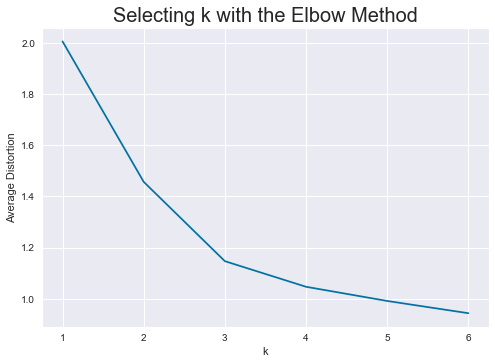

In [22]:
# figure(figsize=(14, 3), dpi=80)
plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average Distortion')
plt.title('Selecting k with the Elbow Method', fontsize=20)

### Observation - Average Distortion
- The ideal K for the Elbow Curve appears to be at 3. From 4 to 6 the value of adding and additional unit appears to steadily decrease.

In [23]:
K3model = KMeans(n_clusters = 3, random_state=101)
K3model.fit(myData_scaled)
# Instantiating, fiting & predicting for KMeans Object 3 clusters

KMeans(n_clusters=3, random_state=101)

In [24]:
myData_raw['K3_ClientProfile'] = K3model.labels_

In [25]:
myK3_ClientProfile = myData_raw.groupby('K3_ClientProfile').mean()

In [26]:
myK3_ClientProfile['population_segment_count'] = myData_raw.groupby('K3_ClientProfile')['Avg_Credit_Limit'].count().values
myK3_ClientProfile

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,population_segment_count
K3_ClientProfile,,,,,,
0,33782.383420,5.515544,3.489637,0.981865,2.000000,386
1,12174.107143,2.410714,0.933036,3.553571,6.870536,224
2,141040.000000,8.740000,0.600000,10.900000,1.080000,50


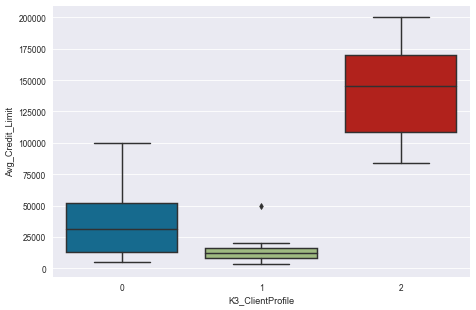

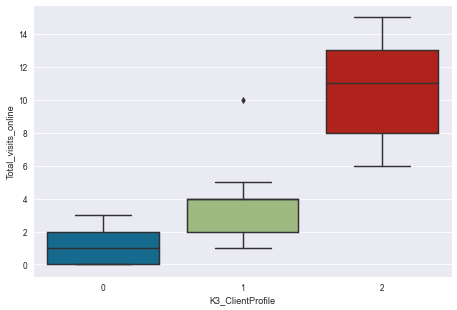

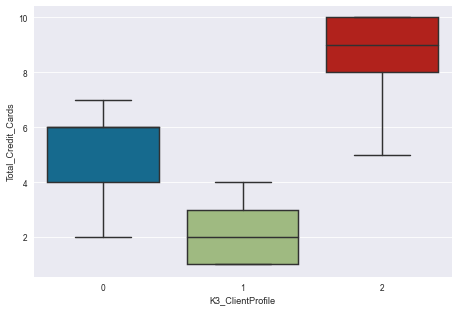

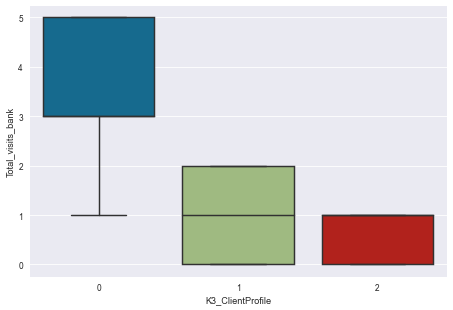

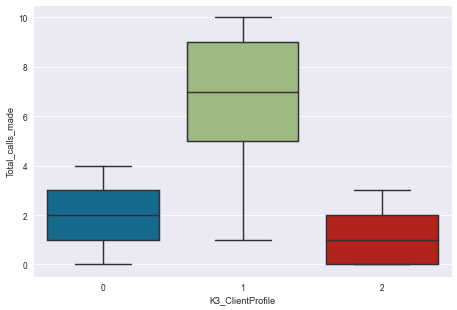

In [27]:
for i in range(5):
    figure(figsize=(9, 6), dpi=60)
    # sns.boxplot(x=myData_raw[cols[i]])
    sns.boxplot(y=myData_raw[cols[i]],x=myData_raw['K3_ClientProfile'])
    plt.show()

### Insights

*Clusters Analysis*
We dont have age demographic data but considering the features, I believe the features I previously labeled interactions may indicate what age group the customers are likely to be in. Below are my perscribed labels and the analysis supporting the labels.


 - **Cluster 0** : *Baby Boomers*
     - Avg_Credit_Limit is average to low but has large spread with the media at about 3K.
     - Total_visits_online for this customer segment is very low, some don't even use it.
     - This segment tends to have from 4 to 6 cards.
     - The customers in this segment visit the Bank in person more than any other group.
     - Total_calls_made for this customer profile is low with some calling two times.


 - **Cluster 1** : *Generation X*
    - Avg_Credit_Limit in this cluster is very very low and does not have much spread. 
        - Just about all in this segment have less than 2.5K with one exception which is an outlier at 5K.
    - Total_visits_online is low.
        - Again, there is one outlier in this segmentation.
    - This cluster of customers have very low amount of Total_Credit_Cards with the maximum at 4 cards and the median at 2 cards.
    - Total_visits_bank are anywhere from 0 to 2
    - This customer segment is the one to call the most and have the largest spread of Total_calls_made with most making 7 calls


 - **Cluster 2** : *Millennials*
    - Avg_Credit_Limit is the highest in this segment. The spread is large but even the lowest average credit limit in this client base is the higher than the median in any other cluster. 
    - This segment is the highest 10 being the max and the median around 11 for Total_visits_online 
    - With Total_Credit_Cards, again, this segment is the highest 10 being the max and the median around 9.
    - This customer segment has a 1 Total_visits_bank count.
    - Total_calls_made is the lowest in this customer profile of the 3 segments.

## Hierarchical Clustering

#### Create Linkage Object

In [28]:
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram

In [29]:
methods=["AVERAGE", "CENTROID", "COMPLETE", "SINGLE", "WARD"]
df_linkage=[]
# for organizing models

linkageObject_average = linkage(y=myData_scaled, method='average', metric='euclidean')
linkageObject_centroid = linkage(y=myData_scaled, method='centroid', metric='euclidean')
linkageObject_complete = linkage(y=myData_scaled, method='complete', metric='euclidean')
linkageObject_single = linkage(y=myData_scaled, method='single', metric='euclidean')
linkageObject_ward = linkage(y=myData_scaled, method='ward', metric='euclidean')
# Instantiating Linkage Object to be able to plot the Dendrogram

df_linkage.append(linkageObject_average)
df_linkage.append(linkageObject_centroid)
df_linkage.append(linkageObject_complete)
df_linkage.append(linkageObject_single)
df_linkage.append(linkageObject_ward)
# Adding to list

c_AVERAGE, coph_dists_AVERAGE = cophenet(linkageObject_average , pdist(myData_scaled))
c_CENTROID, coph_dists_CENTROID = cophenet(linkageObject_centroid , pdist(myData_scaled))
c_COMPLETE, coph_dists_COMPLETE = cophenet(linkageObject_complete , pdist(myData_scaled))
c_SINGLE, coph_dists_SINGLE = cophenet(linkageObject_single , pdist(myData_scaled))
c_WARD, coph_dists_WARD = cophenet(linkageObject_ward , pdist(myData_scaled))
# Calculated cophenet coefficients

print('c_AVERAGE ', c_AVERAGE)
print('c_CENTROID ', c_CENTROID)
print('c_COMPLETE ', c_COMPLETE)
print('c_SINGLE ', c_SINGLE)
print('c_WARD ', c_WARD)

c_AVERAGE  0.8977080867389372
c_CENTROID  0.8939385846326323
c_COMPLETE  0.8599730607972423
c_SINGLE  0.7391220243806552
c_WARD  0.7415156284827493


### Observations
 - AVERAGE linkage is the best method at 0.8977 with CENTROID right behind at 0.8939

## Plot Dendrogram

In [31]:
t = '~'*25
myP = 5

~~~~~~~~~~~~~~~~~~~~~~~~~  [  AVERAGE  ]  ~~~~~~~~~~~~~~~~~~~~~~~~~


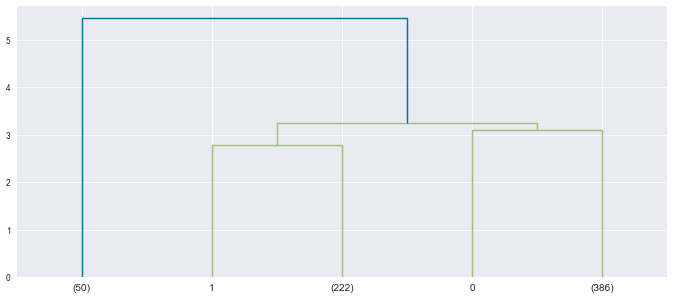

In [32]:
i=0
print(t," [ ",methods[i]," ] ",t)
figure(figsize=(14, 6), dpi=60)
dendrogram(df_linkage[i],truncate_mode='lastp', p=myP)
plt.show()

# Clustering the Data

In [33]:
from scipy.cluster.hierarchy import fcluster

In [34]:
max_d = 3
# setting level

HClusters = fcluster(Z=linkageObject_average, t=max_d, criterion='distance')
# Instantiating fcluster object based on Linkage Object

In [35]:
myData_raw['HCluster_ClientProfile'] = HClusters
# Adding Clusters to dataframe

In [36]:
myK3_ClientProfile = myData_raw.groupby('HCluster_ClientProfile').mean()
# Grouping Clusters in dataframe

In [37]:
myK3_ClientProfile['population_segment_count'] = myData_raw.groupby('HCluster_ClientProfile')['Avg_Credit_Limit'].count().values
# Adding unique values to count segmented population

myK3_ClientProfile
# Display

,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,K3_ClientProfile,population_segment_count
HCluster_ClientProfile,,,,,,,
1,141040.000000,8.740000,0.600000,10.900000,1.080000,2.000000,50
2,12197.309417,2.403587,0.928251,3.560538,6.883408,1.000000,223
3,33541.450777,5.520725,3.492228,0.984456,2.010363,0.002591,386
4,100000.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1


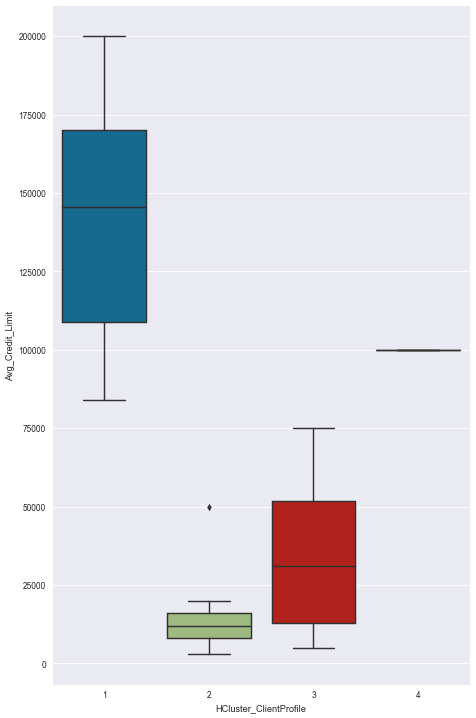

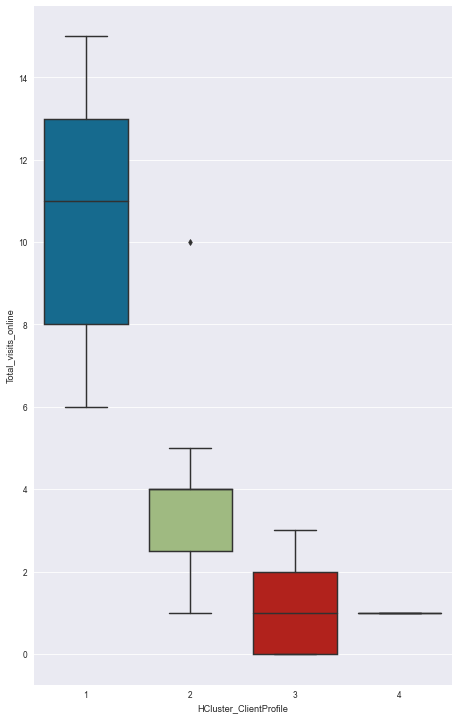

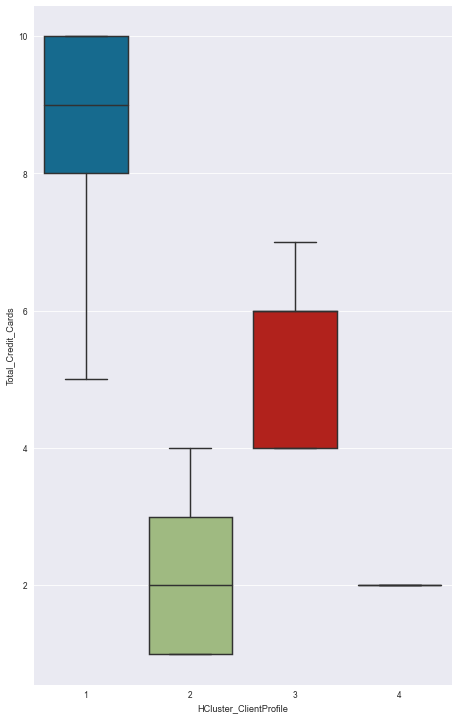

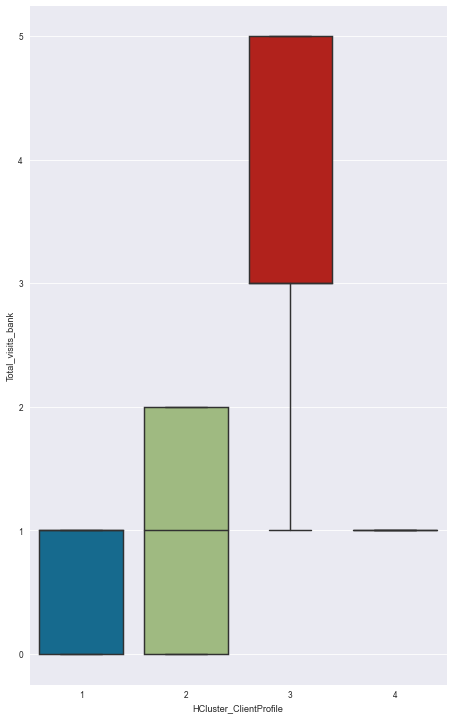

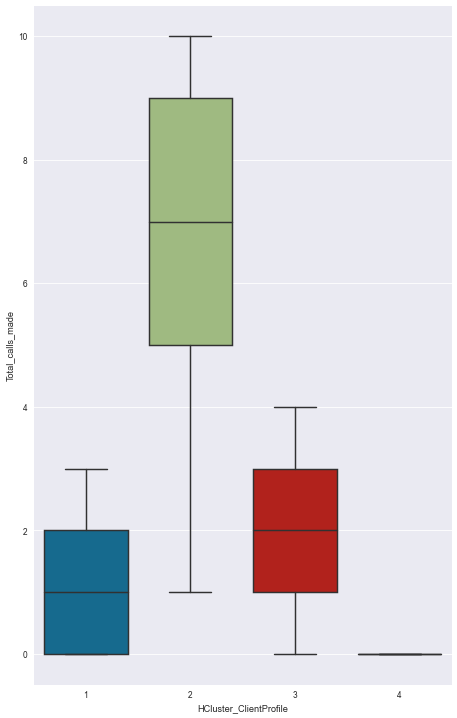

In [38]:
for i in range(5):
    figure(figsize=(9, 15), dpi=60)
    # sns.boxplot(x=myData_raw[cols[i]])
    sns.boxplot(y=myData_raw[cols[i]],x=myData_raw['HCluster_ClientProfile'])
    plt.show()

### Insights
Again same age groupings seem to have appeared with the labels changing order but still similar characteristics.

 - **Cluster 1** : *Millennials*
     - Avg_Credit_Limit is high with large spread.
     - This segment is the highest 10 being the max and the median around 11 for Total_visits_online 
     - This segment tends to have the most cards with at least 5.
     - Not many visit the Bank, if at all.
     - Total_calls_made for this customer profile is low with most calling just once.


 - **Cluster 2** : *Generation X*
    - Avg_Credit_Limit in low with tight spread & one outlier.
    - Total_visits_online is medium.
    - This cluster of customers have very low amount of Total_Credit_Cards at 2 cards.
    - Total_visits_bank are one 1 with a max of 2.
    - This customer segment is the one to call the most and have the largest spread of Total_calls_made.


 - **Cluster 3** : *Baby Boomers*
    - Avg_Credit_Limit large spread of data however it is on the lower end cluster. 
    - Total_visits_online for this customer segment is very low.
    - With Total_Credit_Cards, this segment is between the other two clusters.
    - This customer segment has a high Total_visits_bank count with lots of spread. It is much higher than the other two clusters
    - Total_calls_made has a median of 2.
    
 - **Cluster 4** : This one is isolated. Not much value in analysis.

## Silhouette Scores

In [39]:
from sklearn.metrics import silhouette_score
silhouette_score(myData_scaled,myData_raw['K3_ClientProfile'])
# silhouette_score

0.5157182558881063

In [40]:
from sklearn.metrics import silhouette_score
silhouette_score(myData_scaled,myData_raw['HCluster_ClientProfile'])
# silhouette_score

0.47495143595793504

#### Observation
Based on the silhouette_score, both methods were terrible at clusting the distance. However, the K Means clustering appears to have been more successful by aproximately 4 percent. 

**Business Insights**
**Key Questions:**
A. How many different segments of customers are there?
 - Using both models, we were able to segment the customers into three categories.
B. How are these segments different from each other?
 - The segments are distinguished by primarily the method of communication/interaction with the bank via On Premise, Phone and Online.
C. What are your recommendations to the bank on how to better market to and service these customers?
 - The recommendation of how to proceed would be to collect more data if possible as the amount of features were limited. Time data would have also been a useful feature to capture such as how frequent the interactions were.
 - If the *AllLife Credit Card* chooses to move forward with using the market segmentation, the data appears to represent three categories for which clients appear to be by age group given the aspect of technology (online visits), in person visits (face-to-face) and a mix of in between (phone communications). 

While Demographic data was not collected, some clear distinctions did appear on interactions.

The clients who visited most online tended to call less and very few visit the bank, if at all appear to exhibit interactions consistent with Millennials or those who are tech savvy.

The clients who visited the bank the most, occasionally called but very rarely did they go online, if at all but occasionally used the phone. These were the ones that visited the branch the most. The complete opposite, they appear to be tech adverse.

The clients who called the most seemed to have a blend of both, however, they overwhelmingly used the phone as the preferred method of communication.


**Remedy to the Problem:** To run personalized campaign to target new customers should be to **Generation X** & **Millennials**. These two groups are the least intensive on man hours as they can be mostly satisfied with a phone call or through online means.

To upsell to existing customers, the market segmentation should be developed around the **Generation X** & **Baby Boomer**  as this is the largest customer based. In person upselling and building the relationship will likely be the place of most impact.

For the Generation X, the bank should have contact with them through face to face, phone and online. This method may be most approriate. 

By focusing on these three clusters/segmentations and splitting the efforts 

Having more contact with the client will give the opportunity to build a better business relationship and listen to the client's needs. By having more communication through their preferred method of contact, it will be possible to collect more data on what is the common issue and how issues have been resolved in the past to their satisfaction.
